# Training with Back-propagation Algorithms

Back-propagation (BP) trainings have become foundations in machine learning algorithms. In this section, we are going to talk about how to train models with BP.

In [1]:
import brainpy as bp
import brainpy.math as bm

Here, we train two kinds of models to classify MNIST dataset. The first is ANN models commonly used in deep neural networks. The second is SNN models.

## Train a ANN model

We first build a three layer ANN model:

```bash

i >> r >> o
```

where the recurrent layer ``r`` is a LSTM cell, the output ``o`` is a linear readout.

In [2]:
class ANNModel(bp.dyn.DynamicalSystem):
    def __init__(self, num_in, num_rec, num_out):
        super(ANNModel, self).__init__()
        self.rec = bp.layers.LSTM(num_in, num_rec)
        self.out = bp.layers.Dense(num_rec, num_out)

    def update(self, sha, x):
        x = self.rec(sha, x)
        x = self.out(sha, x)
        return x

Before training this model, we get and clean the data we want.

In [3]:
root = r"D:\data\fashion-mnist"
train_dataset = bp.datasets.FashionMNIST(root,
                                         train=True,
                                         transform=None,
                                         target_transform=None,
                                         download=True)
test_dataset = bp.datasets.FashionMNIST(root,
                                        train=False,
                                        transform=None,
                                        target_transform=None,
                                        download=True)

# Standardize data
import numpy as np
x_train = np.array(train_dataset.data, dtype=bm.dftype()) / 255
y_train = np.array(train_dataset.targets, dtype=bm.ditype())

Then, we start to train our defined ANN model with ``brainpy.train.BPTT`` training interface.

In [4]:
# model
model = ANNModel(28, 100, 10)

# loss function
def loss_fun(predicts, targets):
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(axis=-1) == targets)
    return loss, {'acc': acc}

# optimizer
optimizer=bp.optim.Adam(lr=1e-3)

# trainer
trainer = bp.train.BPTT(model,
                        loss_fun=loss_fun,
                        loss_has_aux=True,
                        optimizer=optimizer)

In [5]:
trainer.fit([bm.asarray(x_train),
             bm.asarray(y_train)],
            batch_size=256,
            num_epoch=10)

Train 100 steps, use 5.8233 s, train loss 0.71408, acc 0.7578125
Train 200 steps, use 4.6053 s, train loss 0.58021, acc 0.796875
Train 300 steps, use 5.3632 s, train loss 0.59812, acc 0.76953125
Train 400 steps, use 4.4055 s, train loss 0.55029, acc 0.78515625
Train 500 steps, use 4.5634 s, train loss 0.42883, acc 0.859375
Train 600 steps, use 4.4417 s, train loss 0.43089, acc 0.83203125
Train 700 steps, use 4.3874 s, train loss 0.50011, acc 0.81640625
Train 800 steps, use 4.4480 s, train loss 0.35544, acc 0.8515625
Train 900 steps, use 4.4295 s, train loss 0.49531, acc 0.82421875
Train 1000 steps, use 4.5088 s, train loss 0.34906, acc 0.87890625
Train 1100 steps, use 4.3934 s, train loss 0.35866, acc 0.90625
Train 1200 steps, use 4.4541 s, train loss 0.38998, acc 0.8671875
Train 1300 steps, use 4.4055 s, train loss 0.3596, acc 0.86328125
Train 1400 steps, use 4.3874 s, train loss 0.34075, acc 0.86328125
Train 1500 steps, use 4.4722 s, train loss 0.36413, acc 0.8671875
Train 1600 steps

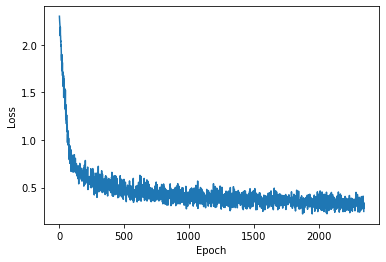

In [6]:
import matplotlib.pyplot as plt

plt.plot(trainer.train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Train a SNN model

Similarly, ``brainpy.train.BPTT`` can also be used to train SNN models.

We first build a three layer SNN model:

```bash

i >> [exponential synapse] >> r >> [exponential synapse] >> o
```

In [7]:
class SNNModel(bp.dyn.DynamicalSystem):
  def __init__(self, num_in, num_rec, num_out):
    super(SNNModel, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out

    # neuron groups
    self.i = bp.neurons.InputGroup(num_in, mode=bp.modes.training)
    self.r = bp.neurons.LIF(num_rec, tau=10, V_reset=0, V_rest=0, V_th=1.,
                            mode=bp.modes.training)
    self.o = bp.neurons.LeakyIntegrator(num_out, tau=5, mode=bp.modes.training)

    # synapse: i->r
    self.i2r = bp.synapses.Exponential(self.i, self.r, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(), tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.),
                                       mode=bp.modes.training)
    # synapse: r->o
    self.r2o = bp.synapses.Exponential(self.r, self.o, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(), tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.),
                                       mode=bp.modes.training)

  def update(self, shared, spike):
    self.i2r(shared, spike)
    self.r2o(shared)
    self.r(shared)
    self.o(shared)
    return self.o.V.value

As the model receives spiking inputs, we define functions that are necessary to transform the continuous values to spiking data.

In [8]:
def current2firing_time(x, tau=20., thr=0.2, tmax=1.0, epsilon=1e-7):
  x = np.clip(x, thr + epsilon, 1e9)
  T = tau * np.log(x / (x - thr))
  T = np.where(x < thr, tmax, T)
  return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
  labels_ = np.array(y, dtype=bm.ditype())
  sample_index = np.arange(len(X))

  # compute discrete firing times
  tau_eff = 2. / bm.get_dt()
  unit_numbers = np.arange(nb_units)
  firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=bm.ditype())

  if shuffle:
    np.random.shuffle(sample_index)

  counter = 0
  number_of_batches = len(X) // batch_size
  while counter < number_of_batches:
    batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
    all_batch, all_times, all_units = [], [], []
    for bc, idx in enumerate(batch_index):
      c = firing_times[idx] < nb_steps
      times, units = firing_times[idx][c], unit_numbers[c]
      batch = bc * np.ones(len(times), dtype=bm.ditype())
      all_batch.append(batch)
      all_times.append(times)
      all_units.append(units)
    all_batch = np.concatenate(all_batch).flatten()
    all_times = np.concatenate(all_times).flatten()
    all_units = np.concatenate(all_units).flatten()
    x_batch = bm.zeros((batch_size, nb_steps, nb_units))
    x_batch[all_batch, all_times, all_units] = 1.
    y_batch = bm.asarray(labels_[batch_index])
    yield x_batch, y_batch
    counter += 1

Now, we can define a BP trainer for this SNN model.

In [9]:
def loss_fun(predicts, targets):
    predicts, mon = predicts
    # L1 loss on total number of spikes
    l1_loss = 1e-5 * bm.sum(mon['r.spike'])
    # L2 loss on spikes per neuron
    l2_loss = 1e-5 * bm.mean(bm.sum(bm.sum(mon['r.spike'], axis=0), axis=0) ** 2)
    # predictions
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(-1) == targets)
    return loss + l2_loss + l1_loss, {'acc': acc}

model = SNNModel(num_in=28*28, num_rec=100, num_out=10)

trainer = bp.train.BPTT(
    model,
    loss_fun=loss_fun,
    loss_has_aux=True,
    optimizer=bp.optim.Adam(lr=1e-3),
    monitors={'r.spike': model.r.spike},
)

The training process is similar to that of the ANN model, instead of the data is generated by the sparse generator function we defined above.

In [10]:
trainer.fit(lambda: sparse_data_generator(x_train.reshape(x_train.shape[0], -1),
                                          y_train,
                                          batch_size=256,
                                          nb_steps=100,
                                          nb_units=28 * 28),
            num_epoch=10)

Train 100 steps, use 22.0941 s, train loss 1.19132, acc 0.6875
Train 200 steps, use 20.2645 s, train loss 0.87256, acc 0.80859375
Train 300 steps, use 21.1350 s, train loss 0.68279, acc 0.87890625
Train 400 steps, use 20.4300 s, train loss 0.72015, acc 0.83984375
Train 500 steps, use 21.5106 s, train loss 0.66263, acc 0.8125
Train 600 steps, use 21.1154 s, train loss 0.58406, acc 0.8515625
Train 700 steps, use 20.9971 s, train loss 0.60017, acc 0.84375
Train 800 steps, use 22.0579 s, train loss 0.51788, acc 0.87109375
Train 900 steps, use 21.6525 s, train loss 0.50461, acc 0.8828125
Train 1000 steps, use 23.0335 s, train loss 0.51658, acc 0.87109375
Train 1100 steps, use 22.1772 s, train loss 0.54877, acc 0.8515625
Train 1200 steps, use 22.9390 s, train loss 0.46686, acc 0.875
Train 1300 steps, use 22.4156 s, train loss 0.42036, acc 0.91015625
Train 1400 steps, use 22.4095 s, train loss 0.48285, acc 0.87109375
Train 1500 steps, use 22.7672 s, train loss 0.47716, acc 0.875
Train 1600 st

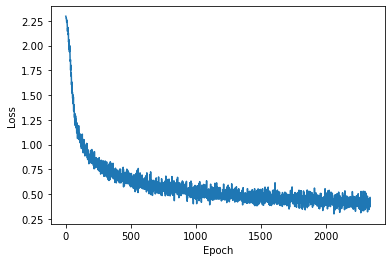

In [11]:
plt.plot(trainer.train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Customize your BP training

Actually, ``brainpy.train.BPTT`` is just one way to perform back-propagation training with your model. You can easily customize your training process.

In the below, we demonstrate how to define a BP training process by hand with the above ANN model.

In [12]:
# packages we need

from time import time
from functools import partial

In [18]:
# define the model
model = ANNModel(28, 100, 10)

In [19]:
# define the loss function
def loss_fun(inputs, targets):
  runner = bp.train.DSTrainer(model, progress_bar=False, numpy_mon_after_run=False)
  predicts = runner.predict(inputs, reset_state=True)
  predicts = bm.max(predicts, axis=1)
  loss = bp.losses.cross_entropy_loss(predicts, targets)
  acc = bm.mean(predicts.argmax(-1) == targets)
  return loss, acc

In [20]:
# define the gradient function which computes the
# gradients of the trainable weights
grad_fun = bm.grad(loss_fun,
                   grad_vars=model.train_vars().unique(),
                   dyn_vars=model.vars(),
                   has_aux=True,
                   return_value=True)

In [21]:
# define the optimizer we need
opt = bp.optim.Adam(lr=1e-3, train_vars=model.train_vars().unique())

In [22]:
# training function

@partial(bm.jit, dyn_vars=model.vars() + opt.vars())
def train(xs, ys):
  grads, loss, acc = grad_fun(xs, ys)
  opt.update(grads)
  return loss, acc

In [23]:
# start training

k = 0
num_batch = 256
running_loss = 0
running_acc = 0
print_step = 100
X_train = bm.asarray(x_train)
Y_train = bm.asarray(y_train)
t0 = time()
for _ in range(10):  # number of epoch
  key = bm.random.DEFAULT.split_key()
  X_train = bm.random.permutation(X_train, key)
  Y_train = bm.random.permutation(Y_train, key)

  for i in range(0, X_train.shape[0], num_batch):
    X = X_train[i: i + num_batch]
    Y = Y_train[i: i + num_batch]
    loss_, acc_ = train(X, Y)
    running_loss += loss_
    running_acc += acc_
    k += 1
    if k % print_step == 0:
      print('Step {}, Used {:.4f} s, Loss {:0.4f}, Acc {:0.4f}'.format(
        k, time() - t0,  running_loss / print_step, running_acc / print_step))
      t0 = time()
      running_loss = 0
      running_acc = 0

Step 100, Used 7.0777 s, Loss 1.1089, Acc 0.6295
Step 200, Used 5.3347 s, Loss 0.5945, Acc 0.7838
Step 300, Used 6.8700 s, Loss 0.5286, Acc 0.8101
Step 400, Used 5.2681 s, Loss 0.4915, Acc 0.8188
Step 500, Used 5.3199 s, Loss 0.4550, Acc 0.8318
Step 600, Used 5.2788 s, Loss 0.4533, Acc 0.8314
Step 700, Used 5.3146 s, Loss 0.4215, Acc 0.8459
Step 800, Used 5.4479 s, Loss 0.4151, Acc 0.8442
Step 900, Used 5.5003 s, Loss 0.3980, Acc 0.8533
Step 1000, Used 5.5045 s, Loss 0.3949, Acc 0.8566
Step 1100, Used 5.3810 s, Loss 0.3897, Acc 0.8558
Step 1200, Used 5.3632 s, Loss 0.3792, Acc 0.8583
Step 1300, Used 5.3024 s, Loss 0.3644, Acc 0.8651
Step 1400, Used 5.3145 s, Loss 0.3774, Acc 0.8596
Step 1500, Used 5.3328 s, Loss 0.3559, Acc 0.8690
Step 1600, Used 5.2903 s, Loss 0.3563, Acc 0.8690
Step 1700, Used 5.3266 s, Loss 0.3583, Acc 0.8687
Step 1800, Used 5.2965 s, Loss 0.3492, Acc 0.8714
Step 1900, Used 5.3309 s, Loss 0.3395, Acc 0.8765
Step 2000, Used 5.2679 s, Loss 0.3302, Acc 0.8774
Step 2100